### Compare SIST parameters for windows from centromeres, neocentromeres, and background genomic regions

Analysis of sequences from centromeres, neocentromeres, and background genomic regions using SIST

In [1]:
from __future__ import division
%pylab inline
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from scipy.signal import medfilt
import seaborn as sns
from Bio import SeqIO
import glob
sns.set_style('ticks')
sns.set_context('paper')
import os
import re
from scipy.stats import ks_2samp

def parse_sist_melt(fn):
    """Parse raw SIST melt output; return an array of probabilities"""
    data = []
    with open(fn,'r') as f:
        for line in f:
            line = line.strip()
            if 'Position' in line or 'WARNING' in line:
                continue
            line = line.split()
            line[0],line[1],line[2] = int(line[0])-1,float(line[1]),float(line[2])
            data.append(line[1])
    return np.array(data)

def parse_sist_cruciform(fn):
    """Parse raw SIST cruciform output; return an array of probabilities"""
    data = []
    with open(fn,'r') as f:
        for line in f:
            line = line.strip()
            if 'Position' in line or 'WARNING' in line:
                continue
            line = line.split()
            line[0],line[1] = int(line[0])-1,float(line[1])
            data.append(line[1])
    return np.array(data)

def stitch_sist(fns,dtype='melt',maxe = 200000):
    """Parse multiple SIST outputs for a region that exceeds the SIST maximum of 10kb;
    stitch together sequences based on the information provided in the filename;
    Example fn format: II_1603582-1643583_0.algM.txt """
    data = None
    for fn in fns:
        fn_split = os.path.basename(fn).split('_')
        
        fn_split[-1] = fn_split[-1].split('.')[0]
                
        offset = int(fn_split[-1])
        
        
        try:
            [s,e] = fn_split[-2].split('-')
            s,e = int(s),int(e)
        except:
            s = 0
            e = maxe
        n = e-s+1
        
        if data is None:
            data = -np.ones(n)
        
        if dtype=='melt':
            sdata = parse_sist_melt(fn)
        else:
            sdata = parse_sist_cruciform(fn)
        data[offset:offset+len(sdata)] = np.maximum(sdata,data[offset:offset+len(sdata)])
        
    return data[data>=0]

def format_horiz_bar(ax,data,labels,yticklabels=[0,1],xlabel=None,xlim=None,xticks=None,
                     colors=['black','white'],iqrscale=1.75):
    ml = ticker.MaxNLocator()
    ml._min_n_ticks=2
    ml._nbins=2
    ax.xaxis.set_major_locator(ml)
    
    mf = ticker.ScalarFormatter(useMathText=True)
    mf.set_powerlimits((-2,2))
    ax.xaxis.set_major_formatter(mf)
    
    bp = sns.boxplot(x=data,y=labels,ax=ax,palette=colors,fliersize=0,width=0.75,orient='h')
    
    if xlim is not None:
        ax.set_xlim(xlim)
    else:
        lnames = set(labels)
        
        upper = -np.inf
        
        for ln in lnames:
            ql,qu = np.percentile(data[labels == ln],q=[25,75])
            iqr = qu-ql
            lu = qu+iqrscale*iqr
            
            if lu > upper:
                upper = lu
        ax.set_xlim(np.min(data),upper)
        
    plt.draw()
    
    if xlabel is not None:
        old_label = xlabel
        try:
            units =  old_label[old_label.index("(") + 1:old_label.rindex(")")]
        except:
            units = ""
        label = old_label.replace("({})".format(units), "")
        exponent_text = ax.xaxis.get_offset_text().get_text().encode('utf-8')
        if len(exponent_text) > 1:
            exponent_text = re.sub("\xE2\x88\x92", "-", exponent_text)
            exponent_text.encode('ascii')
            exponent_text = exponent_text.replace("\\times", "")
            newlab = "{} ({} {})".format(label, exponent_text, units)
        else:
            newlab = xlabel
        ax.xaxis.offsetText.set_visible(False)
        ax.xaxis.set_label_text(newlab,size=10)
    
    ax.set_yticklabels(yticklabels,size=12)
    
    sns.despine(left=True,offset=5)
    ax.tick_params('y',length=0)
    ax.xaxis.set_tick_params(labelsize=10,length=4)

    
def format_vert_bar(ax,data,labels,xticklabels=[0,1],ylabel=None,ylim=None,yticks=None,
                     colors=['black','white'],iqrscale=1.75):
    ml = ticker.MaxNLocator()
    ml._min_n_ticks=2
    ml._nbins=2
    ax.yaxis.set_major_locator(ml)
    
    mf = ticker.ScalarFormatter(useMathText=True)
    mf.set_powerlimits((-2,2))
    ax.yaxis.set_major_formatter(mf)
    
    bp = sns.boxplot(y=data,x=labels,ax=ax,palette=colors,fliersize=0,width=0.4,orient='v')
    
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        lnames = set(labels)
        
        upper = -np.inf
        
        for ln in lnames:
            subs = data[labels == ln]
            if len(subs) > 3:
                ql,qu = np.percentile(subs,q=[25,75])
                iqr = qu-ql
                lu = qu+iqrscale*iqr
            else:
                lu = np.max(data)
            if lu > upper:
                upper = lu
                
        ax.set_ylim(np.min(data),upper)
        
    plt.draw()
    
    if yticks is not None:
        ax.set_yticks(yticks)
    
    
    if ylabel is not None:
        old_label = 'Score ()'
        try:
            units =  old_label[old_label.index("(") + 1:old_label.rindex(")")]
        except:
            units = ""
        label = old_label.replace("({})".format(units), "")
        exponent_text = ax.yaxis.get_offset_text().get_text().encode('utf-8')
        if len(exponent_text) > 1:
            exponent_text = re.sub("\xE2\x88\x92", "-", exponent_text)
            exponent_text.encode('ascii')
            exponent_text = exponent_text.replace("\\times", "")
            newlab = "{} ({} {})".format(label, exponent_text, units)
        else:
            newlab = ylabel
        ax.yaxis.set_label_text(newlab,size=9)
        ax.yaxis.offsetText.set_visible(False)
    
    ax.set_xticklabels(xticklabels,size=10)
    
    sns.despine(bottom=True,offset=5)
    ax.tick_params('x',length=0)
    ax.yaxis.set_tick_params(labelsize=9,length=4)
    
# Define colors:
blue = '#1f78b4'
brown = '#b15928'
gray = '#d9d9d9'

Populating the interactive namespace from numpy and matplotlib


#### Human - alphoid sequence

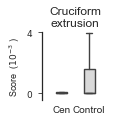

In [62]:

data = []
labels = []

fns = glob.glob('../data/sist/human/bacs/*.algC.txt')
pfxs = set([fn.rsplit('_',1)[0] for fn in fns])

for pfx in pfxs:
    try:
        x = stitch_sist(glob.glob(pfx+'*.algC.txt'),dtype='c')
    except:
        x = parse_sist_cruciform(glob.glob(pfx+'*')[0])
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')


fns = glob.glob('../data/sist/human/matched_random/*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')

    

fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)
    
colors = [brown,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
ax.set_title('Cruciform\nextrusion',size=12)
# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors)
format_vert_bar(ax,data,labels,names,ylabel='SIST score',colors=colors,ylim=
                (-0.5e-3,4e-3),yticks=(0,4e-3))

plt.savefig('../figures/human_sist_cruc.svg')


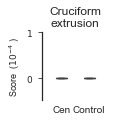

In [12]:

data = []
labels = []

fns = glob.glob('../data/sist/human/bacs_individ/dyz3/*.algC.txt')
pfxs = set([fn.rsplit('_',1)[0] for fn in fns])

for pfx in pfxs:
    try:
        x = stitch_sist(glob.glob(pfx+'*.algC.txt'),dtype='c')
    except:
        x = parse_sist_cruciform(glob.glob(pfx+'*')[0])
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')


fns = glob.glob('../data/sist/human/bacs_individ/d5z2/*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')

    

fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)
    
colors = [brown,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
ax.set_title('Cruciform\nextrusion',size=12)
# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors)
format_vert_bar(ax,data,labels,names,ylabel='SIST score',colors=colors,ylim=
                (-0.5e-4,1e-4),yticks=(0,1e-4))

# plt.savefig('../figures/human_sist_cruc.svg')



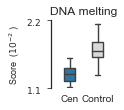

In [65]:

data = []
labels = []

fns = glob.glob('../data/sist/human/bacs/*.algM.txt')
pfxs = set([fn.rsplit('_',1)[0] for fn in fns])

for pfx in pfxs:
    try:
        x = stitch_sist(glob.glob(pfx+'*.algM.txt'),dtype='melt')
    except:
        x = parse_sist_cruciform(glob.glob(pfx+'*')[0])
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')


fns = glob.glob('../data/sist/human/matched_random/*.algM.txt')
for fn in fns:
    x = parse_sist_melt(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')

    

fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)
    
colors = [blue,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
ax.set_title('DNA melting',size=12)
# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors)
format_vert_bar(ax,data,labels,names,ylabel='SIST score',colors=colors,ylim=(1.1e-2,2.2e-2),yticks=(1.1e-2,2.2e-2))
plt.savefig('../figures/human_sist_melt.svg')

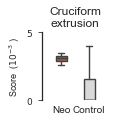

In [4]:
data = []
labels = []

fns = glob.glob('../data/sist/human/neocen/*.algC.txt')
pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
for pfx in pfxs:
    x = stitch_sist(glob.glob(pfx+'*.algC.txt'),dtype='c')
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Neo')

fns = glob.glob('../data/sist/human/matched_random/*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')

fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)
    
colors = [brown,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Neo','Control']
# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors)
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,yticks=(0,5e-3),ylim=(0,5e-3))
ax.set_title('Cruciform\nextrusion',size=12)
plt.savefig('../figures/human_sist_neocen_cruc.svg')

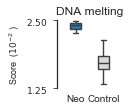

In [5]:
data = []
labels = []

fns = glob.glob('../data/sist/human/neocen/*.algM.txt')
pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
for pfx in pfxs:
    x = stitch_sist(glob.glob(pfx+'*.algM.txt'),dtype='melt')
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Neo')

fns = glob.glob('../data/sist/human/matched_random/*.algM.txt')
for fn in fns:
    x = parse_sist_melt(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')

fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)
    
# colors = ['#78aed2',gray]
colors = [blue,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Neo','Control']
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,yticks=(1.25e-2,2.5e-2),ylim=(1.25e-2,2.5e-2))

ax.set_title('DNA melting',size=12)
plt.savefig('../figures/human_sist_neocen_melt.svg')

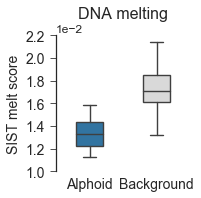

In [9]:
fns = glob.glob('../data/sist/human/matched_random/*.algM.txt')

random = []

for fn in fns:
    x = parse_sist_melt(fn)
    L = len(x)
    random.append(np.sum(x)/L)

    
fns = glob.glob('../data/sist/human/bacs/*.algM.txt')

cen = []

pfxs = set([fn.rsplit('_',1)[0] for fn in fns])

for pfx in pfxs:
    try:
        x = stitch_sist(glob.glob(pfx+'*.algM.txt'),dtype='melt')
    except:
        x = parse_sist_melt(glob.glob(pfx+'*')[0])
    L = len(x)
    cen.append(np.sum(x)/L)

fns = glob.glob('../data/sist/human/neocen/*.algM.txt')

neocen = []

pfxs = set([fn.rsplit('_',1)[0] for fn in fns])

for pfx in pfxs:
    x = stitch_sist(glob.glob(pfx+'*.algM.txt'),dtype='melt')
    L = len(x)
    neocen.append(np.sum(x)/L)

fig = plt.figure(figsize=(2.4,2.5))
ax = fig.add_subplot(111)
colors = ['#1f78b4','#d9d9d9']
bp = sns.boxplot(y=cen+random,x=['Alphoid']*len(cen)+['Background']*len(random),
            fliersize=0,palette=colors,width=0.4)
ax.xaxis.set_tick_params(length=0)
ax.set_xticklabels(['Alphoid','Background'],size=14)
setp(ax.get_yticklabels(),size=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2),size=14)
ax.yaxis.get_offset_text().set_fontsize(12)
ax.set_ylabel('SIST melt score',size=14)
plt.ylim(1e-2,2.2e-2)
sns.despine(ax=ax,trim=True,bottom=True)
plt.title('DNA melting',size=16,y=1.08)
plt.savefig('../figures/human_sist_melt.svg')

#### Chicken - unique cen

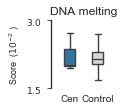

In [61]:
# data = []
# labels = []

# fns = glob.glob('../data/sist/chicken/unique_cen/*.algM.txt')
# pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
# for pfx in pfxs:
#     x = stitch_sist(glob.glob(pfx+'*.algM.txt'),dtype='melt')
#     L = len(x)
#     data.append(np.sum(x)/L)
#     labels.append('Cen')

# fns = glob.glob('../data/sist/chicken/matched_random/*.algM.txt')
# pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
# for pfx in pfxs:
#     x = stitch_sist(glob.glob(pfx+'*.algM.txt'),dtype='melt')
#     L = len(x)
#     data.append(np.sum(x)/L)
#     labels.append('Control')

    

fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)

colors = [blue,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(1.5e-2,3e-2),
                yticks=(1.5e-2,3e-2))
plt.title('DNA melting',size=12)
plt.savefig('../figures/chicken_sist_melt.svg')

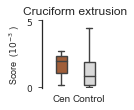

In [59]:

# data = []
# labels = []

# fns = glob.glob('../data/sist/chicken/unique_cen/*.algC.txt')
# pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
# for pfx in pfxs:
#     x = stitch_sist(glob.glob(pfx+'*.algC.txt'),dtype='cruc')
#     L = len(x)
#     data.append(np.sum(x)/L)
#     labels.append('Cen')

# fns = glob.glob('../data/sist/chicken/matched_random/*.algC.txt')
# pfxs = set([fn.rsplit('_',1)[0] for fn in fns])

# for pfx in pfxs:
#     x = stitch_sist(glob.glob(pfx+'*.algC.txt'),dtype='cruc')
#     L = len(x)
#     data.append(np.sum(x)/L)
#     labels.append('Control')

    
fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)

colors = [brown,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(-1e-4,5e-3),
                yticks=(0,5e-3))
plt.title('Cruciform extrusion',size=12)
plt.savefig('../figures/chicken_sist_cruciform.svg')

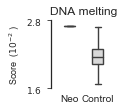

In [8]:
data = []
labels = []

fns = glob.glob('../data/sist/chicken/neocen/*.algM.txt')
pfxs = set([fn.rsplit('_',1)[0] for fn in fns])

for pfx in pfxs:
    x = stitch_sist(glob.glob(pfx+'*.algM.txt'),dtype='melt')
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Neo')


fns = glob.glob('../data/sist/chicken/matched_random/*.algM.txt')

pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
for pfx in pfxs:
    x = stitch_sist(glob.glob(pfx+'*.algM.txt'),dtype='melt')
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')

fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)

colors = [blue,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Neo','Control']
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(1.6e-2,2.8e-2),
                yticks=(1.6e-2,2.8e-2))
plt.title('DNA melting',size=12)
plt.savefig('../figures/chicken_sist_neocen_melt.svg')

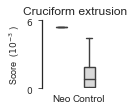

In [10]:
data = []
labels = []

fns = glob.glob('../data/sist/chicken/neocen/*.algC.txt')
pfxs = set([fn.rsplit('_',1)[0] for fn in fns])

for pfx in pfxs:
    x = stitch_sist(glob.glob(pfx+'*.algC.txt'),dtype='c')
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Neo')


fns = glob.glob('../data/sist/chicken/matched_random/*.algC.txt')

pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
for pfx in pfxs:
    x = stitch_sist(glob.glob(pfx+'*.algC.txt'),dtype='c')
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')

# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors,xlim=(0,6e-3))
fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)

colors = [blue,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Neo','Control']
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(0,6e-3),
                yticks=(0,6e-3))
plt.title('Cruciform extrusion',size=12)
plt.savefig('../figures/chicken_sist_neocen_cruc.svg')

#### Pombe

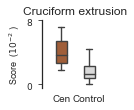

In [13]:
data = []
labels = []

fns = glob.glob('../data/sist/pombe/cen/*.algC.txt')
pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
for pfx in pfxs:
    x = stitch_sist(glob.glob(pfx+'*.algC.txt'),dtype='c')
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')

fns = glob.glob('../data/sist/pombe/matched_random/*.algC.txt')
pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
for pfx in pfxs:
    x = stitch_sist(glob.glob(pfx+'*.algC.txt'),dtype='c')
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')

fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)

colors = [brown,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors,iqrscale=1.6)
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(-5e-4,8e-3),
                yticks=(0,8e-3))
plt.title('Cruciform extrusion',size=12)
plt.title('Cruciform extrusion',size=12)
plt.savefig('../figures/pombe_sist_cruciform.svg')

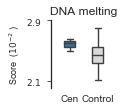

In [16]:
# data = []
# labels = []

# fns = glob.glob('../data/sist/pombe/cen/*.algM.txt')
# pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
# for pfx in pfxs:
#     x = stitch_sist(glob.glob(pfx+'*.algM.txt'),dtype='melt')
#     L = len(x)
#     data.append(np.sum(x)/L)
#     labels.append('Cen')

# fns = glob.glob('../data/sist/pombe/matched_random/*.algM.txt')
# pfxs = set([fn.rsplit('_',1)[0] for fn in fns])
# for pfx in pfxs:
#     x = stitch_sist(glob.glob(pfx+'*.algM.txt'),dtype='melt')
#     L = len(x)
#     data.append(np.sum(x)/L)
#     labels.append('Control')

fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)

colors = [blue,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors,iqrscale=1.7)
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(2e-2,2.9e-2),
                yticks=(2.1e-2,2.9e-2))
plt.title('DNA melting',size=12)
plt.savefig('../figures/pombe_sist_melt.svg')

#### Cerevisiae

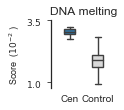

In [20]:
data = []
labels = []

fns = glob.glob('../data/sist/sacCer/cen/*.algM.txt')
for fn in fns:
    x = parse_sist_melt(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')

fns = glob.glob('../data/sist/sacCer/matched_random/*.algM.txt')
for fn in fns:
    x = parse_sist_melt(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')
    
fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)
colors = [blue,gray]

data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(0.75e-2,3.5e-2),
                yticks=(1e-2,3.5e-2))

plt.title('DNA melting',size=12)
plt.savefig('../figures/sc2_sist_melt.svg')

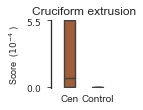

In [24]:
data = []
labels = []

fns = glob.glob('../data/sist/sacCer/cen/*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')

fns = glob.glob('../data/sist/sacCer/matched_random/*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')
    
fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)

colors = [brown,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors,iqrscale=0.5)
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(-0.1e-4,0.55e-3),
                yticks=(0,0.55e-3))


plt.title('Cruciform extrusion',size=12)
plt.savefig('../figures/sc2_sist_cruc.svg')

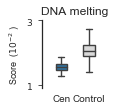

In [33]:
# data = []
# labels = []

# fns = glob.glob('../data/sist/mouse/misat/*.algM.txt')
# for fn in fns:
#     x = parse_sist_melt(fn)
#     L = len(x)
#     data.append(np.sum(x)/L)
#     labels.append('Cen')

# fns = glob.glob('../data/sist/mouse/matched_random_misat/*.algM.txt')
# for fn in fns:
#     x = parse_sist_melt(fn)
#     L = len(x)
#     data.append(np.sum(x)/L)
#     labels.append('Control')
    
fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)
colors = [blue,gray]

data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(0.9e-2,3e-2),
                yticks=(1e-2,3e-2))

plt.title('DNA melting',size=12)
plt.savefig('../figures/misat_sist_melt.svg')

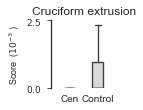

In [36]:
data = []
labels = []

fns = glob.glob('../data/sist/mouse/misat//*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')

fns = glob.glob('../data/sist/mouse/matched_random_misat//*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')
    
fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)

colors = [brown,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors,iqrscale=0.5)
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(-0.1e-4,0.25e-2),
                yticks=(0,0.25e-2))


plt.title('Cruciform extrusion',size=12)
plt.savefig('../figures/misat_sist_cruc.svg')

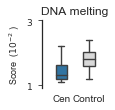

In [34]:
data = []
labels = []

fns = glob.glob('../data/sist/mouse/masat/*.algM.txt')
for fn in fns:
    x = parse_sist_melt(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')

fns = glob.glob('../data/sist/mouse/matched_random_masat/*.algM.txt')
for fn in fns:
    x = parse_sist_melt(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')
    
fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)
colors = [blue,gray]

data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(0.9e-2,3e-2),
                yticks=(1e-2,3e-2))

plt.title('DNA melting',size=12)
plt.savefig('../figures/masat_sist_melt.svg')

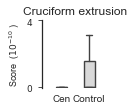

In [51]:
data = []
labels = []

fns = glob.glob('../data/sist/mouse/masat//*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')

fns = glob.glob('../data/sist/mouse/matched_random_masat//*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')
    
fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)

colors = [brown,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors,iqrscale=0.5)
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(-0.1e-10,0.4e-9),
                yticks=(0,0.4e-9))


plt.title('Cruciform extrusion',size=12)
plt.savefig('../figures/masat_sist_cruc.svg')

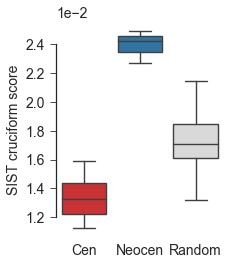

In [15]:

fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111)
colors = ['#e31a1c','#1f78b4','#d9d9d9']
sns.boxplot(y=cen+neocen+random,x=['cen']*len(cen)+['neocen']*len(neocen)+['random']*len(random),
            fliersize=0,palette=colors)
ax.xaxis.set_tick_params(length=0)
ax.set_xticklabels(['Cen','Neocen','Random'],size=14)
setp(ax.get_yticklabels(),size=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2),size=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.set_ylabel('SIST cruciform score',size=14)
# plt.ylim(-0.0001,0.004)
sns.despine(ax=ax,trim=True,bottom=True)
# plt.savefig('../figures/human_sist_cruc.svg')

# sns.boxplot(y=list(random)+list(cen)+list(neocen),x=['random']*len(random)+['cen']*len(cen)+['neocen']*len(neocen),
#             fliersize=0)
# plt.xticks([])
# plt.xlim([-0.5,3.5])
# sns.despine(bottom=True,trim=True)


    

In [157]:
yeasts = ['sacCer','sacMik','sacKud','sacDar','sacCas']

dset = 'algM'

data = []
hue = []
name = []

for yeast in yeasts:
    ydir = '../data/sist/'+yeast
    
    fns = glob.glob(ydir+'/matched_random/*'+dset+'.txt')
    
    for fn in fns:
        if dset == 'algM':
            x = parse_sist_melt(fn)
        else:
            x = parse_sist_cruciform(fn)
        
        L = len(x)
        
        data.append(np.sum(x[:])/L)
        name.append(yeast)
        hue.append('rand')
        
    fns = glob.glob(ydir+'/cen/*'+dset+'.txt')
    
    for fn in fns:
        if dset == 'algM':
            x = parse_sist_melt(fn)
        else:
            x = parse_sist_cruciform(fn)
        
        L = len(x)
            
        data.append(np.sum(x[:])/L)
        name.append(yeast)
        hue.append('cen')

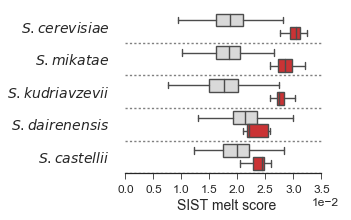

In [158]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

colors = ['#d9d9d9','#e31a1c']
sns.boxplot(x=data,y=name,hue=hue,palette=colors,fliersize=0)
# ax.set_xlim(-0.00001,0.0002)
ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2),size=10)
ax.set_yticklabels(['$\it{S. cerevisiae}$',
                    '$\it{S. mikatae}$',
                    '$\it{S. kudriavzevii}$',
                    '$\it{S. dairenensis}$',
                    '$\it{S. castellii}$'],size=14)
setp(ax.get_xticklabels(),size=12)
ax.axes.yaxis.set_tick_params(length=0)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.legend_.remove()
ax.set_xlabel('SIST melt score',size=14)
ax.hlines([0.5,1.5,2.5,3.5,4.5],0,0.035,linestyles='dotted',colors='grey')
sns.despine(left=True,trim=True)
plt.savefig('../figures/yeast_sist_melt.svg')

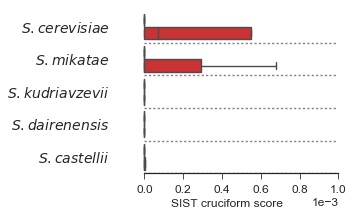

In [153]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

colors = ['#d9d9d9','#e31a1c']
sns.boxplot(x=data,y=name,hue=hue,palette=colors,fliersize=0)
# ax.set_xlim(-0.00001,0.0002)
ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2),size=10)
ax.set_yticklabels(['$\it{S. cerevisiae}$',
                    '$\it{S. mikatae}$',
                    '$\it{S. kudriavzevii}$',
                    '$\it{S. dairenensis}$',
                    '$\it{S. castellii}$'],size=14)
setp(ax.get_xticklabels(),size=12)
ax.axes.yaxis.set_tick_params(length=0)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.legend_.remove()
ax.set_xlabel('SIST cruciform score',size=12)
ax.set_xlim(-1.5e-4,1e-3)
ax.hlines([0.5,1.5,2.5,3.5,4.5],0,1e-3,linestyles='dotted',colors='grey')
sns.despine(left=True,trim=True)
plt.savefig('../figures/yeast_sist_cruc.svg')

In [164]:
fns = glob.glob('../data/sist/mouse/matched_random_masat/*.algC.txt')

random_ma = []

for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
#     print L
    random_ma.append(np.sum(x)/L)

    
fns = glob.glob('../data/sist/mouse/masat/*.algC.txt')

ma = []

for fn in fns:

    x = parse_sist_cruciform(fn)
    L = len(x)
    ma.append(np.sum(x)/L)

fns = glob.glob('../data/sist/mouse/matched_random_misat//*.algC.txt')

random_mi = []

for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    random_mi.append(np.sum(x)/L)


    
fns = glob.glob('../data/sist/mouse/misat/*.algC.txt')

cen = []

for fn in fns:

    x = parse_sist_cruciform(fn)
    L = len(x)
    cen.append(np.sum(x)/L)

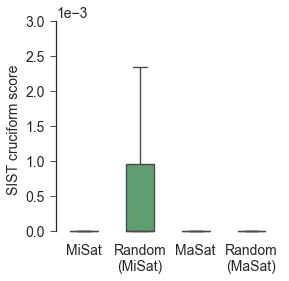

In [172]:

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
# colors = ['#e31a1c','#1f78b4','#d9d9d9']
sns.boxplot(y=cen+random_mi+ma+random_ma,x=['cen']*len(cen)+['misat_rand']*len(random_mi)+['masat']*len(ma) + ['masat_rand']*len(random_ma),
            fliersize=0,width=0.5)
ax.xaxis.set_tick_params(length=0)
ax.set_xticklabels(['MiSat','Random\n(MiSat)','MaSat','Random\n(MaSat)'],size=14)
setp(ax.get_yticklabels(),size=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2),size=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.set_ylabel('SIST cruciform score',size=14)
plt.ylim(-0.0001,0.003)
sns.despine(ax=ax,trim=True,bottom=True)
# plt.savefig('../figures/human_sist_cruc.svg')

# sns.boxplot(y=list(random)+list(cen)+list(neocen),x=['random']*len(random)+['cen']*len(cen)+['neocen']*len(neocen),
#             fliersize=0)
# plt.xticks([])
# plt.xlim([-0.5,3.5])
# sns.despine(bottom=True,trim=True)


plt.savefig('../figures/mouse_sist_cruc.svg')



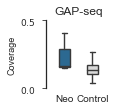

In [8]:
def read_gap_seq_bed(bedfn):
    data = []
    with open(bedfn,'r') as f:
        for line in f:
            line = line.rstrip().split()
            data.append(float(line[-1]))
    return data

data = []
labels = []

neocen = read_gap_seq_bed('../data/gap_seq_neocen.bed')
data.extend(neocen)
labels.extend(['Neo']*len(neocen))

control = read_gap_seq_bed('../data/gap_seq_background.bed')
data.extend(control)
labels.extend(['Control']*len(control))

fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)
    
colors = ['#1b6ca2',gray]
data = np.array(data)
labels = np.array(labels)
names = ['Neo','Control']
# format_horiz_bar(ax,data,labels,names,xlabel='GAP-seq coverage',colors=colors)
format_vert_bar(ax,data,labels,names,ylabel='Coverage',colors=colors,ylim=(0,0.5),yticks=(0,0.5))
ax.set_title('GAP-seq',size=12)
plt.savefig('../figures/human_gap_seq.svg')

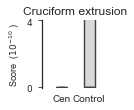

In [3]:
data = []
labels = []

fns = glob.glob('../data/sist/rice/cen/*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')

fns = glob.glob('../data/sist/rice/matched_random/*.algC.txt')
for fn in fns:
    x = parse_sist_cruciform(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')
    
fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)

colors = [brown,gray]
data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
# format_horiz_bar(ax,data,labels,names,xlabel='SIST score',colors=colors,iqrscale=0.5)
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(-0.1e-10,0.4e-9),
                yticks=(0,0.4e-9))


plt.title('Cruciform extrusion',size=12)
# plt.savefig('../figures/masat_sist_cruc.svg')

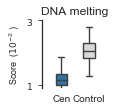

In [4]:
data = []
labels = []

fns = glob.glob('../data/sist/rice/cen/*.algM.txt')
for fn in fns:
    x = parse_sist_melt(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Cen')

fns = glob.glob('../data/sist/rice/matched_random/*.algM.txt')
for fn in fns:
    x = parse_sist_melt(fn)
    L = len(x)
    data.append(np.sum(x)/L)
    labels.append('Control')
    
fig = plt.figure(figsize=(1,1.25))
ax = fig.add_subplot(111)
colors = [blue,gray]

data = np.array(data)
labels = np.array(labels)
names = ['Cen','Control']
format_vert_bar(ax,data,labels,names,ylabel='Score',colors=colors,ylim=(0.9e-2,3e-2),
                yticks=(1e-2,3e-2))

plt.title('DNA melting',size=12)
# plt.savefig('../figures/masat_sist_melt.svg')